![svgviewer-png-output (4).png](<attachment:svgviewer-png-output (4).png>)
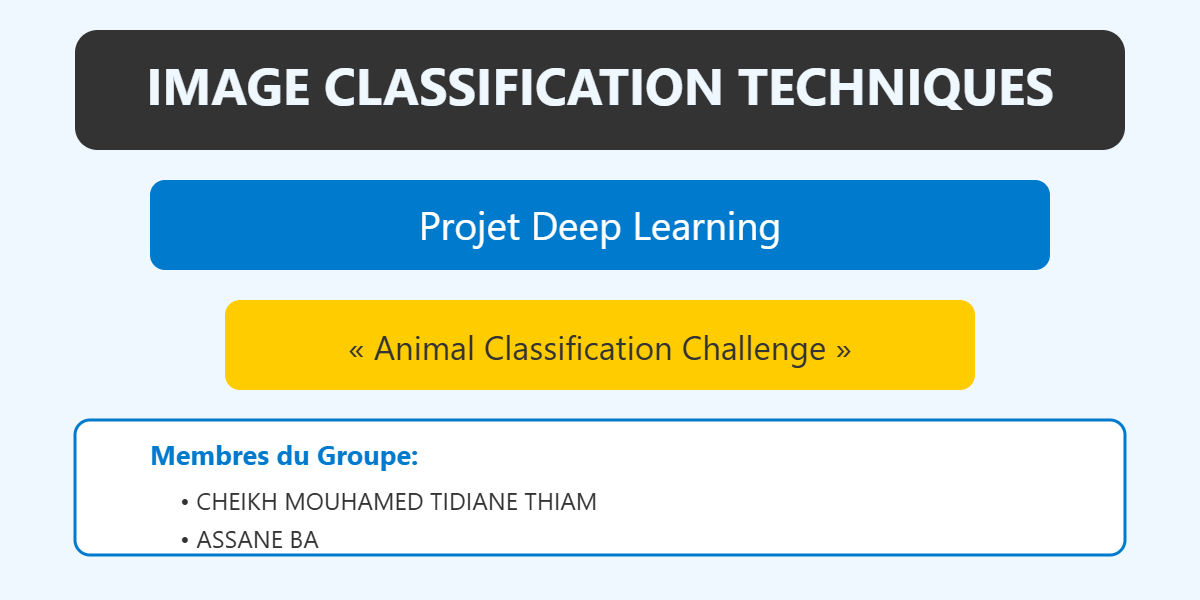

# Description
L'objectif de ce projet est de créer un modèle d'apprentissage automatique pour prédire avec précision la probabilité qu'une image contienne un zèbre, par opposition à un éléphant. Même si cela peut être une tâche facile pour les humains, Notre ordinateur la trouvera un peu plus difficile. Pour se faire nous avons mis en place un plan d'étude.

# Collecte de données
Pour avoir ces images des centaines de pièges photographiques ont été installés dans le parc national du Serengeti, en Tanzanie. Le jeu de données d’apprentissage contient 13 999 images de zébres et d'éléphants et le jeu de données test contient 5 000 images. Toutes les images ont été téléchargées depuis Zooniverse et ont été redimensionnées à 330x330 pixels.

# L'objectif
L'objectif est d'ouvrir une nouvelle ère dans la surveillance de la santé des réserves fauniques les plus importantes d'Afrique. Ces classifications aideront les écologistes à découvrir quelles stratégies de gestion fonctionnent le mieux pour protéger ces espèces emblématiques.



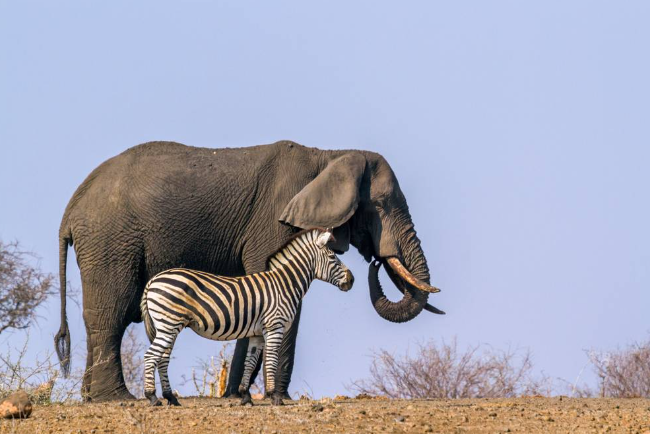

# ***Aperçu du Travail :***
L’objectif de ce travail est de créer un algorithme de classification binaire pour distinguer les zèbres et les éléphants dans un ensemble de données d’images animalières. Le jeu de données d’apprentissage contenait 13 999 images et le jeu de données de test contenait 5 000 images.

# **Importation des bibliothèques nécessaires pour construire de notre modèle d'apprentissage**

In [1]:
import os  # Module pour les interactions avec le système de fichiers et les opérations liées aux chemins
import numpy as np  # Bibliothèque pour les opérations numériques et les tableaux multidimensionnels
import pandas as pd  # Bibliothèque pour la manipulation et l'analyse de données, notamment les DataFrames
from sklearn.model_selection import StratifiedKFold  # Classe pour effectuer une validation croisée stratifiée
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D  # Modules pour définir les couches des modèles de réseaux de neurones
from tensorflow.keras.models import Sequential, Model  # Classes pour créer des modèles de réseaux de neurones séquentiels et fonctionnels
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Classe pour effectuer l'augmentation d'images en temps réel
from tensorflow.keras.applications import MobileNetV2  # Module pour utiliser le modèle pré-entraîné MobileNetV2 pour le transfert de connaissances
import tensorflow
from sklearn.model_selection import train_test_split  # Fonction pour diviser le jeu de données en ensembles d'entraînement et de test

# Redimensionnement

In [2]:
# Définir les dimensions des images et la taille des lots
img_width = 224 
img_height = 224 # Les dimensions des images pour le modèle MobileNetV2 sont de 224 x 224 pixels
batch_size = 32 
epochs = 15 

In [3]:
# Fonction pour charger un échantillon d'images à partir d'un répertoire
def load_sample_images_from_directory(directory, sample_size=1100, batch_size=32):
    image_list = []
    count = 0
    for filename in os.listdir(directory):
        if count >= sample_size:
            break  # Arrêter du chargement après la taille d'échantillon spécifiée
        filepath = os.path.join(directory, filename)
        if os.path.isfile(filepath) and filename.lower().endswith(('.jpg', '.jpeg', '.png', '.gif')):
            try:
                img = tensorflow.keras.preprocessing.image.load_img(
                    filepath,
                    target_size=(img_width, img_height),
                    color_mode="rgb"
                )
                img_array = tensorflow.keras.preprocessing.image.img_to_array(img)
                img_array /= 255.0
                image_list.append(img_array)
                count += 1
                if len(image_list) == batch_size:
                    yield np.array(image_list)
                    image_list = []
            except Exception as e:
                print(f"Skipping invalid image: {filepath}")
                print(f"Error: {e}")
                continue
    if image_list:
        yield np.array(image_list)

In [4]:
 # Chargez un plus petit échantillon d'étiquettes et combinez les données
sample_size = 1100  # Ajustez la taille de l’échantillon si nécessaire
train_elephants_imgs = load_sample_images_from_directory("./train_elephants", sample_size)
train_zebras_imgs = load_sample_images_from_directory("./train_zebras", sample_size)
test_imgs = load_sample_images_from_directory("./test", sample_size)

In [5]:
# Convertir les générateurs en listes de tableaux NumPy
train_elephants_imgs = list(train_elephants_imgs)
train_zebras_imgs = list(train_zebras_imgs)
test_imgs = list(test_imgs)

# Aplatir les lots en une seule liste d'images pour chaque classe
train_elephants_imgs = np.concatenate(train_elephants_imgs, axis=0)
train_zebras_imgs = np.concatenate(train_zebras_imgs, axis=0)

# Vérifier que le nombre d'étiquettes correspond au nombre d'images
train_elephants_labels = np.zeros(len(train_elephants_imgs), dtype=int)
train_zebras_labels = np.ones(len(train_zebras_imgs), dtype=int)

# Concaténer les données et les étiquettes
X_sample = np.concatenate((train_elephants_imgs, train_zebras_imgs), axis=0)
y_sample = np.concatenate((train_elephants_labels, train_zebras_labels), axis=0)

print(f"Shape of X_sample: {X_sample.shape}")
print(f"Shape of y_sample: {y_sample.shape}")


Shape of X_sample: (2200, 224, 224, 3)
Shape of y_sample: (2200,)


In [6]:
# Divisez les exemples de données en ensembles de formation et de validation
X_train_sample, X_val_sample, y_train_sample, y_val_sample = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42)# Le choix 42 est arbitraire

In [7]:
# Initialiser la validation croisée
n_splits = 5  # You can adjust this number
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
predictions_ensemble = []

In [8]:
# Perform cross-validation
for fold, (train_index, val_index) in enumerate(skf.split(X_train_sample, y_train_sample)):
    print(f"Training fold {fold + 1}...")

    X_train, X_val = X_train_sample[train_index], X_train_sample[val_index]
    y_train, y_val = y_train_sample[train_index], y_train_sample[val_index]

Training fold 1...
Training fold 2...
Training fold 3...
Training fold 4...
Training fold 5...


In [9]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

In [10]:
# Define MobileNetV2 base model mobile_net_v2_ est un modèle pré-entraîné sur ImageNet et exclut la couche supérieure pour la classification
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
base_model.trainable = True

In [11]:
# Create a custom model on top of the base model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [12]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Data generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_datagen = ImageDataGenerator()
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [13]:
# Train the model
model.fit(
        train_generator,
        steps_per_epoch=len(X_train) // batch_size,
        validation_data=val_generator,
        validation_steps=len(X_val) // batch_size,
        epochs=epochs
)

c:\Users\bmd tech\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 254s 4s/step - accuracy: 0.9108 - loss: 0.2193 - val_accuracy: 0.5597 - val_loss: 3.8790
Epoch 2/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 173s 4s/step - accuracy: 0.9677 - loss: 0.0864 - val_accuracy: 0.9261 - val_loss: 0.2987
Epoch 3/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 160s 4s/step - accuracy: 0.9885 - loss: 0.0389 - val_accuracy: 0.9403 - val_loss: 0.1843
Epoch 4/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 162s 4s/step - accuracy: 0.9863 - loss: 0.0427 - val_accuracy: 0.6619 - val_loss: 2.0781
Epoch 5/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 160s 4s/step - accuracy: 0.9883 - loss: 0.0293 - val_accuracy: 0.5142 - val_loss: 11.2574
Epoch 6/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 159s 4s/step - accuracy: 0.9889 - loss: 0.0385 - val_accuracy: 0.8750 - val_loss: 0.5689
Epoch 7/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 158s 4s/step - accuracy: 0.9888 - loss: 0.0445 - val_accuracy: 0.6477 - val_loss: 3.0374
Epoch 8/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 159s 4s/step - accuracy: 0.9904 - loss: 0.0349 - val_accuracy: 0.9801 - 

Epoch 1/15: Au début de l'entraînement, la perte d'entraînement est d'environ 0.0717, avec une précision d'environ 97.50%. Sur les données de validation, la perte est d'environ 0.4227, avec une précision d'environ 92.81%.

Epochs 2-10: Les performances semblent relativement stables pendant ces époques, avec des fluctuations mineures dans la perte et la précision à la fois sur les données d'entraînement et de validation.

Epochs 11-15: Vers la fin de l'entraînement, il y a quelques variations dans les performances, avec des changements dans la perte et la précision sur les données de validation. Notamment, les époques 14 et 15 montrent des performances moins bonnes sur les données de validation, avec une perte de validation élevée et une précision plus faible.

En observant ces résultats, il semble que le modèle ait tendance à bien fonctionner sur les données d'entraînement, avec une perte qui diminue et une précision qui augmente. Cependant, sur les données de validation, il y a des signes de surajustement (overfitting) à partir de l'époque 11, où la perte de validation augmente et la précision diminue. Cela indique que le modèle peut avoir du mal à généraliser aux données qu'il n'a pas vu pendant l'entraînement.

In [14]:
model.save('./zebra_elephant_model.h5')

# Prédictions sur les données de test à l'aide du modèle entraîné.

In [15]:
import numpy as np

# Liste pour stocker les résultats
results = []

# Convertir le premier élément en array pour vérifier sa forme
sample_img = np.array(test_imgs[0])
print("Forme d'une image d'exemple:", sample_img.shape)

# Traiter les images par lots
n_batches = len(test_imgs) // batch_size + (1 if len(test_imgs) % batch_size != 0 else 0)

for batch_idx in range(n_batches):
    start_idx = batch_idx * batch_size
    end_idx = min((batch_idx + 1) * batch_size, len(test_imgs))
    
    try:
        # Convertir le lot en array numpy
        batch_images = np.array(test_imgs[start_idx:end_idx])
        
        # Reshape si nécessaire pour obtenir (batch_size, 224, 224, 3)
        if len(batch_images.shape) > 4:
            batch_images = batch_images.reshape(-1, 224, 224, 3)
        
        print(f"Forme du lot {batch_idx + 1}: {batch_images.shape}")
        
        # Prédire sur le lot
        predictions = model.predict(batch_images, verbose=0)
        labels = [1 if pred >= 0.5 else 0 for pred in predictions]
        
        # Ajouter les résultats
        for i, label in enumerate(labels):
            img_idx = start_idx + i
            results.append([f"image_{img_idx+1}", label])
            
    except Exception as e:
        print(f"Erreur lors de la prédiction du lot {batch_idx+1}: {str(e)}")
        print("Type de l'erreur:", type(e))
        continue

# Afficher les résultats
print("\nRésultats des prédictions:")
for result in results:
    print(f"Image: {result[0]}, Label: {result[1]}")

# Statistiques
if results:
    total_predictions = len(results)
    positive_predictions = sum(1 for r in results if r[1] == 1)
    negative_predictions = sum(1 for r in results if r[1] == 0)
    
    print("\nStatistiques des prédictions:")
    print(f"Total des images prédites: {total_predictions}")
    print(f"Images classées positives: {positive_predictions} ({(positive_predictions/total_predictions)*100:.2f}%)")
    print(f"Images classées négatives: {negative_predictions} ({(negative_predictions/total_predictions)*100:.2f}%)")

Forme d'une image d'exemple: (32, 224, 224, 3)
Forme du lot 1: (1024, 224, 224, 3)
Erreur lors de la prédiction du lot 2: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
Type de l'erreur: <class 'ValueError'>

Résultats des prédictions:
Image: image_1, Label: 1
Image: image_2, Label: 1
Image: image_3, Label: 1
Image: image_4, Label: 1
Image: image_5, Label: 1
Image: image_6, Label: 1
Image: image_7, Label: 0
Image: image_8, Label: 1
Image: image_9, Label: 1
Image: image_10, Label: 1
Image: image_11, Label: 0
Image: image_12, Label: 1
Image: image_13, Label: 1
Image: image_14, Label: 1
Image: image_15, Label: 1
Image: image_16, Label: 1
Image: image_17, Label: 1
Image: image_18, Label: 1
Image: image_19, Label: 1
Image: image_20, Label: 1
Image: image_21, Label: 1
Image: image_22, Label: 1
Image: image_23, Label: 1
Image: image_24, Label: 1
Image: image_25, Label: 1
Image: imag